# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import datetime
%matplotlib inline

# pyspark
from pyspark.sql import SparkSession
import pyspark.sql.functions as f
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType, FloatType
from pyspark.sql import Window
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.classification import GBTClassifier, LogisticRegression, RandomForestClassifier, LinearSVC, DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator,BinaryClassificationEvaluator

In [2]:
# create a Spark session
spark_session = SparkSession.builder.appName("Sparkify").getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
events = (spark_session
          .read
          .json('mini_sparkify_event_data.json.gz')
          .cache())

In [4]:
print("Total number of events: {}".format(events.count()))

Total number of events: 286500


In [5]:
# check a record
events.show(1, truncate=False, vertical=True)

-RECORD 0---------------------------------------------------------------------------------
 artist        | Martha Tilston                                                           
 auth          | Logged In                                                                
 firstName     | Colin                                                                    
 gender        | M                                                                        
 itemInSession | 50                                                                       
 lastName      | Freeman                                                                  
 length        | 277.89016                                                                
 level         | paid                                                                     
 location      | Bakersfield, CA                                                          
 method        | PUT                                                                      

In [47]:
# check the max date and end date
(events
.withColumn("timestamp", f.from_unixtime(f.col('ts')/1000).cast('timestamp'))
.select(f.min(f.date_format("timestamp", "yyyyMMdd")).alias("min"), 
        f.max(f.date_format("timestamp", "yyyyMMdd")).alias("max"))
.show())

+--------+--------+
|     min|     max|
+--------+--------+
|20181001|20181203|
+--------+--------+



In [48]:
events.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [49]:
def get_col_data_type(col_name, df):
    """
    Returns the simple DatatType representation of the given column (string, long, etc...)
    :param col_name, name of the column to get the type.
    :param df, DataFrame
    :return String simple representation of the type.
    """
    col_name = col_name.lower()
    for schema_field in events.schema:
        if col_name == schema_field.name.lower():
            return schema_field.dataType.simpleString()
    return None

def check_column_stats(col_name, df, show_uniques=False):
    """
    Helper function to print out column statistics and the distribution of events 
    per page showing the missing values.
    :param col_name, name of the column to print the statistics.
    :param df, DataFrame
    """
    col_type = get_col_data_type(col_name, df)
    total_events = df.count()
    summary = df.select(col_name).describe().collect()
    distinct_values = df.select(col_name).distinct().count()
    column_events = int(summary[0][1])
    missing_values = total_events - column_events
    
    report_final = """
    *************************************
    * {} ({})
    *************************************
    * - Total events     : {}
    * - Column events    : {} ({}%)
    * - Missing values   : {} ({}%)
    * - Distinct values  : {} ({}%)
    * - Mean             : {}
    * - Stdev            : {}
    * - Min              : {}
    * - Max              : {}
    *************************************
    """.format(col_name, 
               col_type,
               total_events, 
               column_events, 
               int(100 * column_events/total_events), 
               missing_values,
               int(100 * missing_values/total_events),
               distinct_values,
               int(100 * distinct_values/total_events),
               summary[1][1], 
               summary[2][1], 
               summary[3][1], 
               summary[4][1])
    # print report
    print(report_final)
    
    # Show distinct values
    if show_uniques == True:
        (df
        .select(col_name)
        .distinct()
        .show(100, truncate=False))

    # show the distribution of missing values per page
    (df
     .select(
        "page",
        f.when(((f.col(col_name).isNull()) | (f.trim(f.col(col_name).cast("string")) == "")), f.lit(1))
         .otherwise(f.lit(0)).alias("missing"),
        f.when(((f.col(col_name).isNotNull()) & (f.trim(f.col(col_name).cast("string")) != "")), f.lit(1))
         .otherwise(f.lit(0)).alias("ok"))
     .groupBy("page")
     .agg(f.sum("missing").alias("missing"), 
          f.sum("ok").alias("ok"), 
          f.sum(f.lit(1)).alias("total"))
     .orderBy("page")
     .show(100, truncate=False))

### Song Playing

From the bellow report we can see that a significant song playing related information is only present in one Page (NextSong) and the other pages don't have that information at all! **No need to remove anything related with these column at this stage.**

In [50]:
check_column_stats("artist", events)
check_column_stats("song", events)
check_column_stats("length", events)


    *************************************
    * artist (string)
    *************************************
    * - Total events     : 286500
    * - Column events    : 228108 (79%)
    * - Missing values   : 58392 (20%)
    * - Distinct values  : 17656 (6%)
    * - Mean             : 551.0852017937219
    * - Stdev            : 1217.7693079161374
    * - Min              : !!!
    * - Max              : ÃÂlafur Arnalds
    *************************************
    
+-------------------------+-------+------+------+
|page                     |missing|ok    |total |
+-------------------------+-------+------+------+
|About                    |924    |0     |924   |
|Add Friend               |4277   |0     |4277  |
|Add to Playlist          |6526   |0     |6526  |
|Cancel                   |52     |0     |52    |
|Cancellation Confirmation|52     |0     |52    |
|Downgrade                |2055   |0     |2055  |
|Error                    |258    |0     |258   |
|Help                     |1

### Auth
Represents the state of the user authentication when the request was done! We see there are no missing values.

In [51]:
check_column_stats("auth", events, True)


    *************************************
    * auth (string)
    *************************************
    * - Total events     : 286500
    * - Column events    : 286500 (100%)
    * - Missing values   : 0 (0%)
    * - Distinct values  : 4 (0%)
    * - Mean             : None
    * - Stdev            : None
    * - Min              : Cancelled
    * - Max              : Logged Out
    *************************************
    
+----------+
|auth      |
+----------+
|Logged Out|
|Cancelled |
|Guest     |
|Logged In |
+----------+

+-------------------------+-------+------+------+
|page                     |missing|ok    |total |
+-------------------------+-------+------+------+
|About                    |0      |924   |924   |
|Add Friend               |0      |4277  |4277  |
|Add to Playlist          |0      |6526  |6526  |
|Cancel                   |0      |52    |52    |
|Cancellation Confirmation|0      |52    |52    |
|Downgrade                |0      |2055  |2055  |
|Error     

### User information

We can see that user info like first, last name, location, gender are only missing from pages that non-loggedin users can visist like (Help, Home, Login, etc..)

In [52]:
check_column_stats("firstName", events)
check_column_stats("lastName", events)
check_column_stats("gender", events)
check_column_stats("lastName", events)


    *************************************
    * firstName (string)
    *************************************
    * - Total events     : 286500
    * - Column events    : 278154 (97%)
    * - Missing values   : 8346 (2%)
    * - Distinct values  : 190 (0%)
    * - Mean             : None
    * - Stdev            : None
    * - Min              : Adelaida
    * - Max              : Zyonna
    *************************************
    
+-------------------------+-------+------+------+
|page                     |missing|ok    |total |
+-------------------------+-------+------+------+
|About                    |429    |495   |924   |
|Add Friend               |0      |4277  |4277  |
|Add to Playlist          |0      |6526  |6526  |
|Cancel                   |0      |52    |52    |
|Cancellation Confirmation|0      |52    |52    |
|Downgrade                |0      |2055  |2055  |
|Error                    |6      |252   |258   |
|Help                     |272    |1454  |1726  |
|Home       

In [53]:
check_column_stats("sessionId", events)
check_column_stats("userId", events)
check_column_stats("ts", events)


    *************************************
    * sessionId (bigint)
    *************************************
    * - Total events     : 286500
    * - Column events    : 286500 (100%)
    * - Missing values   : 0 (0%)
    * - Distinct values  : 2354 (0%)
    * - Mean             : 1041.526554973822
    * - Stdev            : 726.7762634630741
    * - Min              : 1
    * - Max              : 2474
    *************************************
    
+-------------------------+-------+------+------+
|page                     |missing|ok    |total |
+-------------------------+-------+------+------+
|About                    |0      |924   |924   |
|Add Friend               |0      |4277  |4277  |
|Add to Playlist          |0      |6526  |6526  |
|Cancel                   |0      |52    |52    |
|Cancellation Confirmation|0      |52    |52    |
|Downgrade                |0      |2055  |2055  |
|Error                    |0      |258   |258   |
|Help                     |0      |1726  |1726

### Considerations on dataset

**userId** has some empty values and we can't used these because they may be guest users.

In [54]:
events_cleaned = (events
.filter(f.trim(f.col("userId")) != '') # filter out the unnecessary events
.withColumn("timestamp", f.from_unixtime(f.col('ts')/1000).cast('timestamp')) # convert to proper timestamp type
.withColumn("month", f.date_format("timestamp", "yyyyMM")) # extract month may be necessary
.withColumn("day", f.date_format("timestamp", "yyyyMMdd")))

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

In [55]:
events_prepared = (events_cleaned
                   .withColumn('churned', 
                               f.when(f.col('page') == 'Cancellation Confirmation', 1)
                               .otherwise(0)))

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [56]:
# Reference table that contains unique user information
unique_user_info=(events_prepared
                   .groupBy("userId")
                   .agg(f.when(f.sum("churned") > 0, 1).otherwise(0).alias("churned")))

In [57]:
churned_counts = unique_user_info.groupBy("churned").count()
churned_counts.show()

+-------+-----+
|churned|count|
+-------+-----+
|      1|   52|
|      0|  173|
+-------+-----+



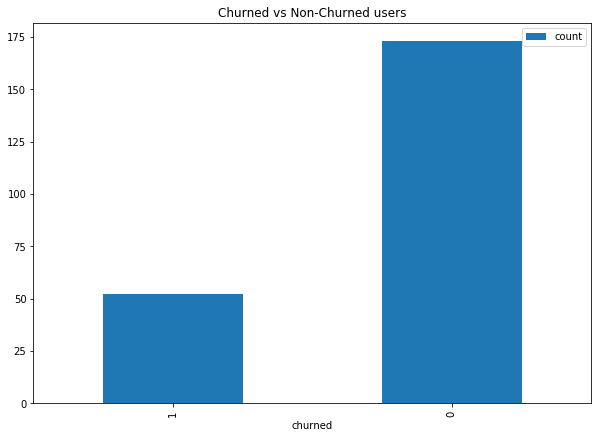

In [58]:
(churned_counts
 .toPandas()
 .plot(title="Churned vs Non-Churned users", x="churned", y=["count"], kind="bar", figsize=(10, 7)))

In [59]:
# Check the statistics of the duration of sessions for both groups
(events_prepared
.select('userId', 'sessionId')
.distinct()
.groupBy('userId')
.count()
.join(unique_user_info, ['userId'])
.groupBy('churned')
.agg(f.avg('count'), 
     f.stddev('count'), 
     f.min('count'), 
     f.max('count'))
).show()

# It seems that people that have churned do less sessions

+-------+------------------+------------------+----------+----------+
|churned|        avg(count)|stddev_samp(count)|min(count)|max(count)|
+-------+------------------+------------------+----------+----------+
|      1|10.326923076923077|  8.61080295917924|         1|        37|
|      0|15.254335260115607|15.866963127421307|         1|       107|
+-------+------------------+------------------+----------+----------+



In [60]:
# Check the statistics of the duration of sessions for both groups
(events_prepared
.select('userId', 
        'sessionId', 
        'timestamp')
.groupBy(f.col('userId'), f.col('sessionId'))
.agg(f.min('timestamp').alias('start_of_session'), 
     f.max('timestamp').alias('end_of_session'))
.select('userId', 
        'sessionId',
        'start_of_session', 
        'end_of_session', 
        (f.col('end_of_session').cast("long") - f.col('start_of_session').cast("long")).alias('duration_in_sec'))
.join(unique_user_info, ['userId'])
.groupBy('churned')
.agg(f.avg('duration_in_sec'), 
     f.stddev('duration_in_sec'), 
     f.min('duration_in_sec'), 
     f.max('duration_in_sec'))
).show()

# The average churned users use the app for less time

+-------+--------------------+----------------------------+--------------------+--------------------+
|churned|avg(duration_in_sec)|stddev_samp(duration_in_sec)|min(duration_in_sec)|max(duration_in_sec)|
+-------+--------------------+----------------------------+--------------------+--------------------+
|      1|  16987.292364990688|          22519.155097809817|                   0|              198001|
|      0|   18171.32171276999|           23594.50469043073|                   0|              267305|
+-------+--------------------+----------------------------+--------------------+--------------------+



In [61]:
# Check the avg number of days between sessions
(events_prepared
.select('userId', 
        'sessionId', 
        'timestamp')
.withColumn('rn', f.row_number().over(Window.partitionBy('userId', 'sessionId').orderBy('timestamp')))
.filter(f.col('rn') == 1)
.drop('rn')
.withColumn('prev_session_ts', 
            f.lag(f.col('timestamp')).over(Window.partitionBy('userId').orderBy('timestamp')))
.withColumn('days_since_last', 
            f.when(f.col('prev_session_ts').isNull(), 0)
            .otherwise(f.datediff(f.col('timestamp'), f.col('prev_session_ts'))))
.join(unique_user_info, ['userId'])
.groupBy('churned')
.agg(f.avg('days_since_last'), 
     f.stddev('days_since_last'))
).show()

# The average days between sessions does not look very different between both groups.

+-------+--------------------+----------------------------+
|churned|avg(days_since_last)|stddev_samp(days_since_last)|
+-------+--------------------+----------------------------+
|      1|   2.260707635009311|           2.979876829036547|
|      0|   3.063281546040167|          4.3541320027388855|
+-------+--------------------+----------------------------+



In [62]:
# Check the avg number of days since the last session for churned clients. 
# To understand if clients that don't use the app for a long time may be more likely to churn
(events_prepared
.join(unique_user_info.filter(f.col("userId") > 0), ['userId'])
.select('userId', 
        'sessionId', 
        'timestamp')
.withColumn('rn', f.row_number().over(Window.partitionBy('userId', 'sessionId').orderBy('timestamp')))
.filter(f.col('rn') == 1)
.drop('rn')
.withColumn('prev_session_ts', 
            f.lag(f.col('timestamp')).over(Window.partitionBy('userId').orderBy('timestamp')))
.withColumn('days_since_last', 
            f.when(f.col('prev_session_ts').isNull(), 0)
            .otherwise(f.datediff(f.col('timestamp'), f.col('prev_session_ts'))))
.withColumn('rn', f.row_number().over(Window.partitionBy('userId').orderBy(f.col('timestamp').desc())))
.filter(f.col('rn') == 1)
.drop('rn', 'sessionId')
.orderBy('userId')
.agg(f.avg('days_since_last'), 
     f.stddev('days_since_last'))
).show()

+--------------------+----------------------------+
|avg(days_since_last)|stddev_samp(days_since_last)|
+--------------------+----------------------------+
|   5.795555555555556|           7.905297600895882|
+--------------------+----------------------------+



In [63]:
# Check the number of errors per client 
# To understand if clients that churned were experencing more errors
(events_prepared
.select('userId', 'status')
.groupBy('userId')
.agg(f.sum((f.when(f.col('status') >= 400, 1).otherwise(0))).alias('errors'))
.join(unique_user_info, ['userId'])
.groupBy('churned')
.agg(f.avg('errors'), f.stddev('errors'))
).show()

+-------+------------------+-------------------+
|churned|       avg(errors)|stddev_samp(errors)|
+-------+------------------+-------------------+
|      1|0.6153846153846154| 0.8437508728558134|
|      0|1.2716763005780347| 1.5852356839534172|
+-------+------------------+-------------------+



In [64]:
# Check the number of songs played per session
(events_prepared
.groupBy('userId', 'sessionId')
.agg(f.sum((f.when(f.col("page") == 'NextSong', 1).otherwise(0))).alias('songs'))
.join(unique_user_info, ['userId'])
.groupBy('churned')
.agg(f.avg('songs'), f.stddev('songs'))).show()

+-------+-----------------+------------------+
|churned|       avg(songs)|stddev_samp(songs)|
+-------+-----------------+------------------+
|      1|67.77281191806331| 88.16811328211362|
|      0|72.64645699128458| 93.67725460573314|
+-------+-----------------+------------------+



In [65]:
# Check the level of users that churned
(events_prepared
.filter(f.col("churned") > 0)
.select('userId', 'level')
.groupBy('level')
.count()
).show()


+-----+-----+
|level|count|
+-----+-----+
| free|   21|
| paid|   31|
+-----+-----+



In [66]:
# Check the gender of users that churned
(events_prepared
.filter(f.col("churned") > 0)
.select('userId', 'gender')
.groupBy('gender')
.count()
).show()

+------+-----+
|gender|count|
+------+-----+
|     F|   20|
|     M|   32|
+------+-----+



In [67]:
churned_info_per_day = (events_prepared
.join(unique_user_info.filter(f.col("churned") > 0), ['userId'])
.groupBy('day')
.agg(
    f.sum((f.when(f.col("page") == 'NextSong', 1).otherwise(0))).alias('songs'),
    f.sum((f.when(f.col('status') >= 400, 1).otherwise(0))).alias('errors'),
    f.sum((f.when(f.col("page") == 'Roll Advert', 1).otherwise(0))).alias('adverts'),
)
.select("day", 
        "songs", 
        "errors", 
        "adverts", 
        f.round((f.col("errors") / f.col("songs")), 5).alias("errors_per_song"),
        f.round((f.col("adverts") / f.col("songs")), 5).alias("adverts_per_song"))
)

In [68]:
churned_info_per_day.orderBy("day").show()

+--------+-----+------+-------+---------------+----------------+
|     day|songs|errors|adverts|errors_per_song|adverts_per_song|
+--------+-----+------+-------+---------------+----------------+
|20181001|  870|     1|     53|        0.00115|         0.06092|
|20181002| 1431|     1|     76|         7.0E-4|         0.05311|
|20181003| 1307|     2|     58|        0.00153|         0.04438|
|20181004| 1157|     1|     72|         8.6E-4|         0.06223|
|20181005| 1329|     0|     13|            0.0|         0.00978|
|20181006|  429|     1|     24|        0.00233|         0.05594|
|20181007|  560|     0|     15|            0.0|         0.02679|
|20181008| 1410|     3|      7|        0.00213|         0.00496|
|20181009| 1661|     1|     38|         6.0E-4|         0.02288|
|20181010| 1397|     1|     22|         7.2E-4|         0.01575|
|20181011| 2047|     3|     54|        0.00147|         0.02638|
|20181012| 1760|     2|     52|        0.00114|         0.02955|
|20181013|  981|     0|  

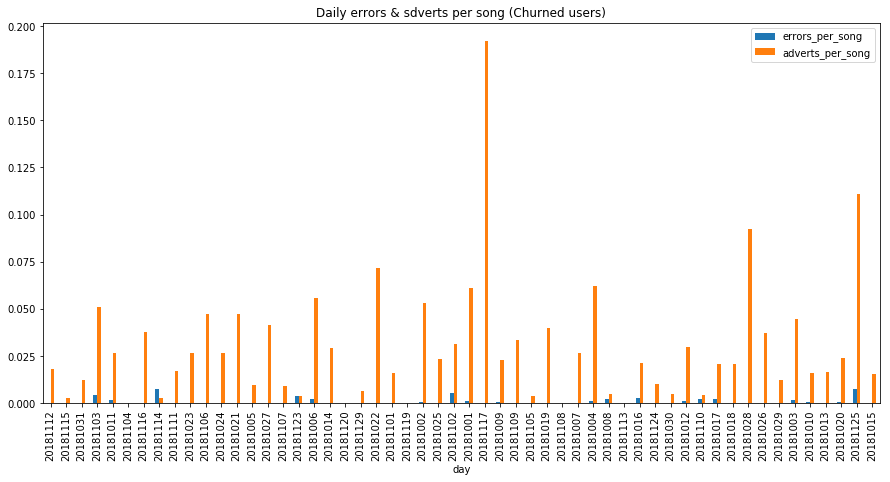

In [69]:
(churned_info_per_day
 .toPandas()
 .plot(title="Daily errors & sdverts per song (Churned users)", 
       x="day", 
       y=["errors_per_song", "adverts_per_song"], 
       kind="bar", 
       figsize=(15, 7)))

In [70]:
not_churned_info_per_day = (events_prepared
.join(unique_user_info.filter(f.col("churned") == 0), ['userId'])
.groupBy('day')
.agg(
    f.sum((f.when(f.col("page") == 'NextSong', 1).otherwise(0))).alias('songs'),
    f.sum((f.when(f.col('status') >= 400, 1).otherwise(0))).alias('errors'),
    f.sum((f.when(f.col("page") == 'Roll Advert', 1).otherwise(0))).alias('adverts'),
)
.select("day", 
        "songs", 
        "errors", 
        "adverts", 
        f.round((f.col("errors") / f.col("songs")), 5).alias("errors_per_song"),
        f.round((f.col("adverts") / f.col("songs")), 5).alias("adverts_per_song"))
)

In [71]:
not_churned_info_per_day.orderBy("day").show()

+--------+-----+------+-------+---------------+----------------+
|     day|songs|errors|adverts|errors_per_song|adverts_per_song|
+--------+-----+------+-------+---------------+----------------+
|20181001| 2488|     2|    106|         8.0E-4|          0.0426|
|20181002| 2095|     4|    102|        0.00191|         0.04869|
|20181003| 1846|     2|     74|        0.00108|         0.04009|
|20181004| 2549|     2|     70|         7.8E-4|         0.02746|
|20181005| 2282|     6|     63|        0.00263|         0.02761|
|20181006| 2524|     4|     86|        0.00158|         0.03407|
|20181007| 1806|     2|     60|        0.00111|         0.03322|
|20181008| 2794|     8|     42|        0.00286|         0.01503|
|20181009| 2768|     3|     93|        0.00108|          0.0336|
|20181010| 3704|     5|     42|        0.00135|         0.01134|
|20181011| 2518|     1|     61|         4.0E-4|         0.02423|
|20181012| 2618|     3|     34|        0.00115|         0.01299|
|20181013| 1442|     2|  

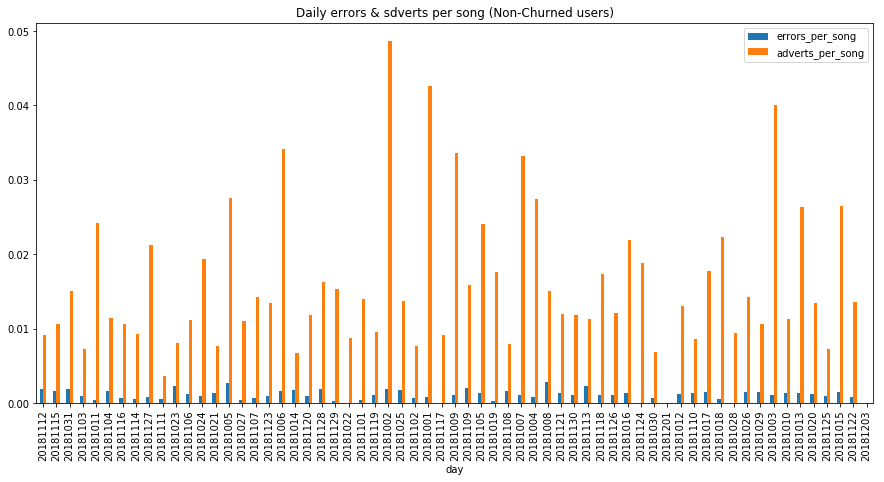

In [72]:
(not_churned_info_per_day
 .toPandas()
 .plot(title="Daily errors & sdverts per song (Non-Churned users)", 
       x="day", 
       y=["errors_per_song", "adverts_per_song"], 
       kind="bar", 
       figsize=(15, 7)))

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

### Features

By the previous analysis I have decided to use the following features:

- gender (categorical)
- level (categorical)
- monthly_avg_num_sessions
- monthly_avg_time_usage
- monthly_avg_errors
- monthly_avg_songs_played
- monthly_avg_adverts_rolled
- daily_avg_num_sessions
- daily_avg_time_usage
- daily_avg_erros
- daily_avg_songs_played
- daily_avg_adverts_rolled


In [73]:
def create_features_per_time_agg(df, time_agg_col, time_agg_prefix):
    """
    Returns a new DataFrame with all session features calculated per the given time_agg_col.
    :param df input dataframe.
    :param time_agg_col column with time information that will be used to aggregate the features.
    :param time_agg_prefix prefix for output column names.
    """
    prefix=time_agg_prefix 
    return (df
     .select("userId", "sessionId", time_agg_col, "timestamp", "status", "page")
     .groupBy("userId", "sessionId", time_agg_col)
     .agg(
         (f.max("timestamp").cast("long") - f.min("timestamp").cast("long")).alias("session_duration"),
         f.sum((f.when(f.col('status') >= 400, 1).otherwise(0))).alias('session_errors'),
         f.sum((f.when(f.col("page") == 'NextSong', 1).otherwise(0))).alias('session_songs'),
         f.sum((f.when(f.col("page") == 'Roll Advert', 1).otherwise(0))).alias('session_advert'))                   
     .groupBy("userId", time_agg_col)
     .agg(
         f.count(f.lit(1)).alias("{}_num_sessions".format(prefix)),
         f.sum("session_duration").alias("{}_time_usage".format(prefix)),
         f.sum("session_errors").alias("{}_errors".format(prefix)),
         f.sum("session_songs").alias("{}_songs".format(prefix)),
         f.sum("session_advert").alias("{}_adverts".format(prefix))
         )
      .groupBy("userId")
      .agg(
         f.avg("{}_num_sessions".format(prefix)).alias("{}_avg_num_sessions".format(prefix)),
         f.avg("{}_time_usage".format(prefix)).alias("{}_avg_time_usage".format(prefix)),
         f.avg("{}_errors".format(prefix)).alias("{}_avg_errors".format(prefix)),
         f.avg("{}_songs".format(prefix)).alias("{}_avg_songs_played".format(prefix)),
         f.avg("{}_adverts".format(prefix)).alias("{}_avg_adverts_rolled".format(prefix))) 
    )

def create_features(df):
    """
    Returns a new DataFrame indexed by userId contaning all the user features.
    :param df input Spark DataFrame.
    """
    daily_features = create_features_per_time_agg(events_prepared, "month", "monthly")
    monthly_features = create_features_per_time_agg(events_prepared, "day", "daily")
    wnd_spec = (Window.partitionBy("userId")
                .orderBy("timestamp")
                .rowsBetween(Window.unboundedPreceding, Window.unboundedFollowing))
    final = (df
             .select("userId",
                     f.when(f.upper(f.col('gender')) == "M", 1).otherwise(0).alias("gender"),
                     f.when(f.last("churned", True).over(wnd_spec) > 0, 1).otherwise(0).alias("churned"),
                     f.when(f.last("level", True).over(wnd_spec) == "paid", 1).otherwise(0).alias("level"))
             .distinct()
             .join(daily_features, ["userId"])
             .join(monthly_features, ["userId"]))
    return final

final_df = create_features(events_prepared).cache()

In [74]:
final_df.groupBy("churned").count().show()

+-------+-----+
|churned|count|
+-------+-----+
|      1|   52|
|      0|  173|
+-------+-----+



In [75]:
final_df.printSchema()

root
 |-- userId: string (nullable = true)
 |-- gender: integer (nullable = false)
 |-- churned: integer (nullable = false)
 |-- level: integer (nullable = false)
 |-- monthly_avg_num_sessions: double (nullable = true)
 |-- monthly_avg_time_usage: double (nullable = true)
 |-- monthly_avg_errors: double (nullable = true)
 |-- monthly_avg_songs_played: double (nullable = true)
 |-- monthly_avg_adverts_rolled: double (nullable = true)
 |-- daily_avg_num_sessions: double (nullable = true)
 |-- daily_avg_time_usage: double (nullable = true)
 |-- daily_avg_errors: double (nullable = true)
 |-- daily_avg_songs_played: double (nullable = true)
 |-- daily_avg_adverts_rolled: double (nullable = true)



/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2961: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4c0154d080>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f4c00fbf2b0>]], dtype=object)

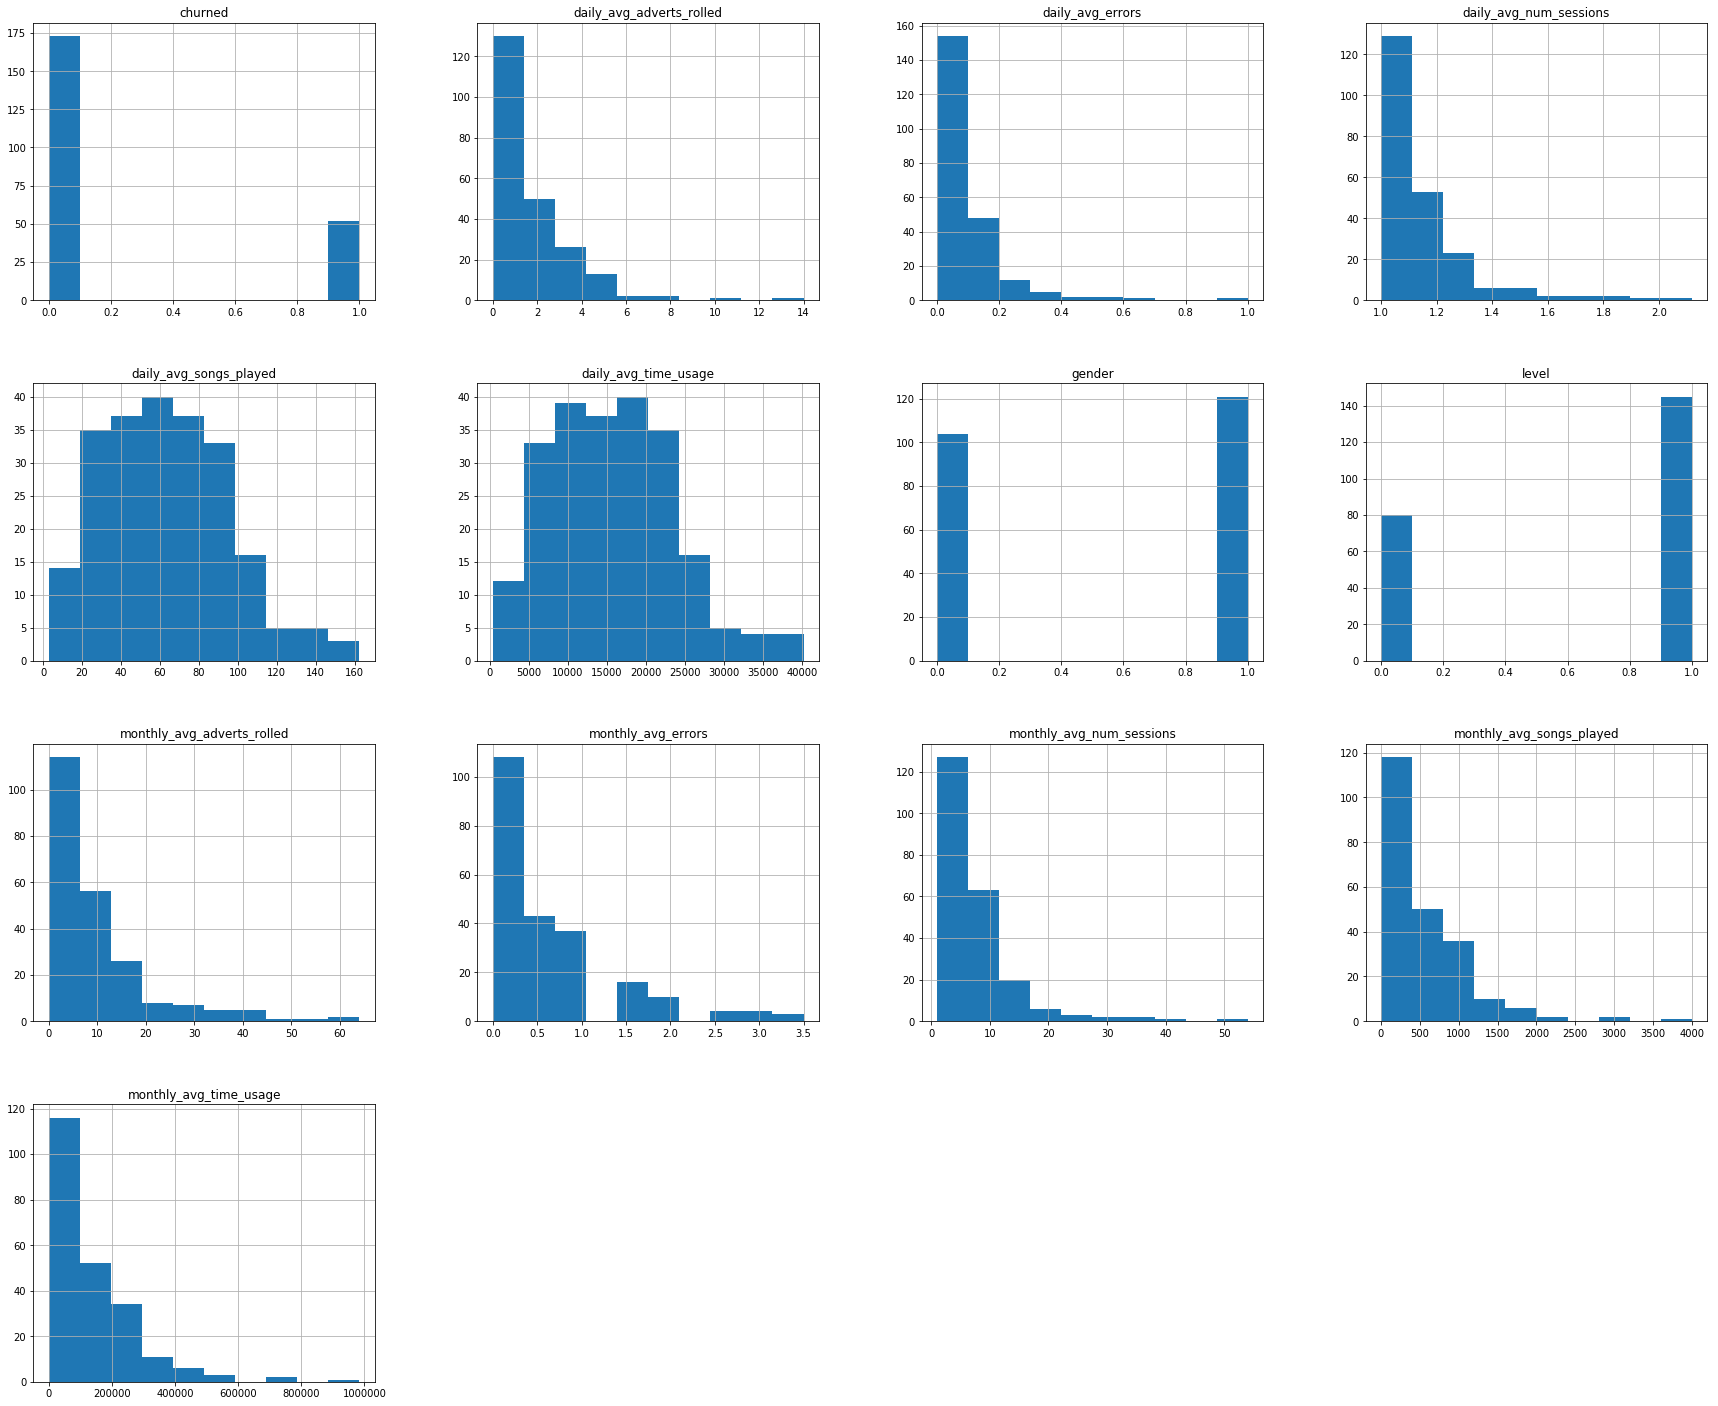

In [76]:
fig = plt.figure(figsize=(30,25))
ax = fig.gca()
final_df.toPandas().hist(ax=ax)

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

### Prepare dataset 

For this we need:
- Choose the features
- Prepare the dataset to feed the Spark ML classifiers and for that we will need to use the **VectorAssembler** to create a column containing a vector with all features.
- Work only the necessary columns
- Perform random split to have a train and test dataset.


In [77]:
# Vector assembler for input features
feature_columns = list(set(final_df.columns) - set(['userId', 'churned']))
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
final_data = assembler.transform(final_df.drop("userId"))
final_data = final_data.select("churned", "features")

train, test = final_data.randomSplit([0.8, 0.2], seed=45)

### Evaluate  models

Now, we need to feed our dataset into different classifiers that make sense to test and see what are the ones that without any tunning give us the best results using the features that we chose.

The models that we are going to test are:
- LinearSVC
- DecisionTreeClassifier
- LogisticRegression
- RandomForestClassifier
- GBTClassifier

In [41]:
def evaluate_model(training_data, test_data, classifier_class, label="churned"):
    """
    Fits, predicts and evaluates the given model with the given training and test dataset.
    :param training_data : Spark DataFrame containing the training data.
    :param test_data : Spark DataFrame containing the test data.
    :param classifier_class_str: Classifier class.
    :param label: label column name.
    :return f1, auc, accuracy scores.
    """
    classifier = classifier_class(labelCol=label)
    model = classifier.fit(training_data)
    predictions = model.transform(test_data)
    
    accuracy_evaluator = MulticlassClassificationEvaluator(labelCol=label, metricName='accuracy')
    accuracy_score = accuracy_evaluator.evaluate(predictions.select(label, 'prediction'))
    f1_evaluator = MulticlassClassificationEvaluator(labelCol=label, metricName='f1')
    f1_score = f1_evaluator.evaluate(predictions.select(label, 'prediction'))
    auc_evaluator = BinaryClassificationEvaluator(labelCol=label)
    auc_score = auc_evaluator.evaluate(predictions.select(label, 'rawPrediction'), 
                                       {auc_evaluator.metricName: "areaUnderROC"})
    return f1_score, auc_score, accuracy_score

In [42]:
models_to_test = ['LinearSVC', 'DecisionTreeClassifier', 'LogisticRegression', 'RandomForestClassifier', 'GBTClassifier']
model_metrics=[]

# test each model and collect the necessary metrics
for classifier in models_to_test:
    print ("Doing: " + classifier)
    f1_score, auc_score, accuracy_score = evaluate_model(train, test, eval(classifier))
    model_metrics.append((classifier, f1_score, auc_score, accuracy_score))

# create pandas df with the models results
model_metrics_df = pd.DataFrame(model_metrics, columns=["model", "f1_score", "auc", "accuracy"])

Doing: LinearSVC
Doing: DecisionTreeClassifier
Doing: LogisticRegression
Doing: RandomForestClassifier
Doing: GBTClassifier


In [43]:
model_metrics_df.head()

,model,f1_score,auc,accuracy
0,LinearSVC,0.745890,0.389610,0.825
1,DecisionTreeClassifier,0.695938,0.500000,0.675
2,LogisticRegression,0.786275,0.783550,0.800
3,RandomForestClassifier,0.824286,0.740260,0.850
4,GBTClassifier,0.723656,0.627706,0.700


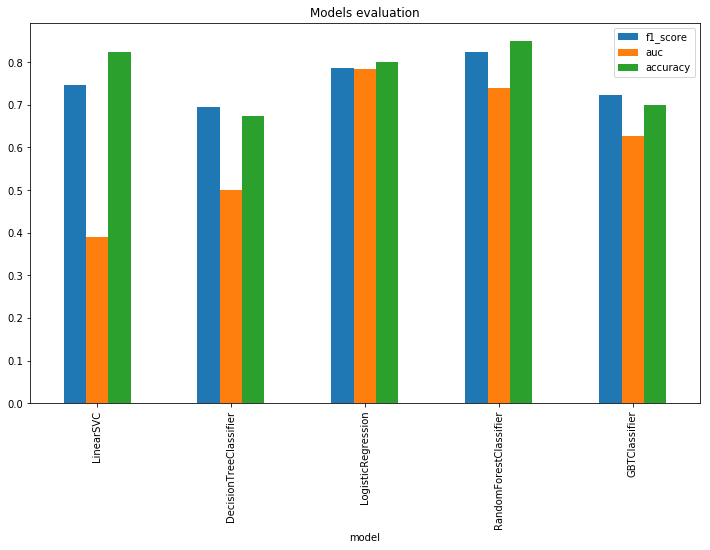

In [45]:
(model_metrics_df
.plot(title="Models evaluation",
      x="model", 
      y=["f1_score", "auc", "accuracy"], 
      kind="bar", 
      figsize=(12, 7)))

### Tunning the best model

At this stage we are picking the best model found at the previous steps and we are trying to optimize it to the F1 score metric.

By the previous analysis I going to optimize 2 best models the **RandomForestClassifier & LogisticRegression** classifiers.

In [12]:
def optimize_model(training_data, test_data, classifier_class, param_grid_fn, label="churned"):
    """
    Optimizes the given classifier algorithm to the F1 score using cross validation and the given param_grid.
    :param training_data : Spark DataFrame containing the training data.
    :param test_data : Spark DataFrame containing the test data.
    :param classifier_class: Classifier class.
    :param param_grid: Param grid to use for optimization.
    :param label: label column name.
    :return model and the pandas dataframe with the F1 score for each of the grid params.
    """
    classifier = classifier_class(labelCol=label)
    pipeline = Pipeline(stages=[classifier])
    crossval = CrossValidator(estimator=pipeline,
                              estimatorParamMaps=param_grid_fn(classifier),
                              evaluator=MulticlassClassificationEvaluator(labelCol=label, metricName='f1'),
                              numFolds=3,
                              parallelism=3)
    
    cv_model = crossval.fit(training_data)
    prediction = cv_model.transform(test_data)
    params = [{p.name: v for p, v in m.items()} for m in cv_model.getEstimatorParamMaps()]
    return cv_model, pd.DataFrame.from_dict([
        {cv_model.getEvaluator().getMetricName(): metric, **ps} 
        for ps, metric in zip(params, cv_model.avgMetrics)
    ])

#### Tune Random Forest

In [13]:
param_grid_rf_fn =(lambda model: ParamGridBuilder()
                 .addGrid(model.maxDepth, [5, 10, 15, 20])
                 .addGrid(model.numTrees, [20, 30, 50, 75])
                 .build())
model_rf, result_rf = optimize_model(train, test, RandomForestClassifier, param_grid_rf_fn)

In [14]:
result_rf.head(500)

,f1,maxDepth,numTrees
0,0.643067,5,20
1,0.694858,5,30
2,0.637023,5,50
3,0.667083,5,75
4,0.682774,10,20
5,0.674796,10,30
6,0.668054,10,50
7,0.694941,10,75
8,0.660410,15,20
9,0.678506,15,30


#### Tune Logistic Regression

In [15]:
param_grid_lr_fn = (lambda model: ParamGridBuilder()
              .addGrid(model.regParam, [0.0, 0.05, 0.1])
              .addGrid(model.elasticNetParam, [0.0, 0.5, 1.0])
              .build())
model_lr, result_lr = optimize_model(train, test, LogisticRegression, param_grid_lr_fn)

In [16]:
result_lr.head(500)

,elasticNetParam,f1,regParam
0,0.0,0.711939,0.00
1,0.5,0.711939,0.00
2,1.0,0.711939,0.00
3,0.0,0.662987,0.05
4,0.5,0.672060,0.05
5,1.0,0.660563,0.05
6,0.0,0.662925,0.10
7,0.5,0.650388,0.10
8,1.0,0.650388,0.10


In [34]:
lr_coefs = pd.DataFrame([(feature,coef) for feature,coef in zip(feature_columns, model_lr.bestModel.stages[0].coefficients.values)], columns=['feature', 'coef'])
lr_coefs.sort_values(by='coef', ascending=False).head(20) 

,feature,coef
9,daily_avg_num_sessions,10.165230
0,level,0.402985
3,gender,0.202917
7,daily_avg_adverts_rolled,0.136517
2,monthly_avg_adverts_rolled,0.035535
1,daily_avg_songs_played,0.012660
11,monthly_avg_time_usage,0.000028
4,daily_avg_time_usage,-0.000137
5,monthly_avg_songs_played,-0.004591
8,monthly_avg_errors,-0.165482


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.

In [6]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Sparkify.ipynb'])

0